In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import os
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

from openpyxl import load_workbook
# Read the Excel file

In [ ]:
geo_code=7
geo_name='Ontario'

# geo_code=6
# geo_name='Nova Scotia'

#Population

In [ ]:
population_data = pd.read_csv("/content/drive/MyDrive/Capstone Project/Population_estimates_2023.csv")

population_data = population_data[population_data['GEO'] == geo_name]
population_data.head(2)

,REF_DATE,GEO,DGUID,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
28,1951-07,Ontario,2016A000235,Persons,249,units,0,v12,7,4615000,NaN,NaN,NaN,0
41,1951-10,Ontario,2016A000235,Persons,249,units,0,v12,7,4665000,NaN,NaN,NaN,0


In [ ]:
columns = ['DGUID', 'UOM','UOM_ID','SCALAR_FACTOR','SCALAR_ID','SCALAR_ID','VECTOR','COORDINATE','STATUS','SYMBOL','TERMINATED','DECIMALS']
population_data = population_data.drop(columns, axis=1)

population_data.columns

#change House_total_price to House_only_total and Land_only_total one by one and run all to see forecast
selected_data = population_data[['REF_DATE', 'VALUE']]
selected_data = selected_data.sort_values(by='REF_DATE')

# Assuming selected_data is your DataFrame

# Convert 'REF_DATE' column to datetime
selected_data['REF_DATE'] = pd.to_datetime(selected_data['REF_DATE'])

# Select data with a year less than 2023
selected_data = selected_data[selected_data['REF_DATE'].dt.year >= 2020]
selected_data = selected_data[selected_data['REF_DATE'].dt.year <= 2023]
selected_data.head(2)
selected_data.set_index('REF_DATE', inplace=True)
selected_data = selected_data.sort_index()


# o_aic_bic=[]
# for p in range(7):
#     for q in range(7):
#         try:
#             model = ARIMA(selected_data, order=(p,1,q))
#             results = model.fit()
#             o_aic_bic.append((p,q,results.aic, results.bic))
#         except:
#             print(p, q, None, None)

# values = pd.DataFrame(o_aic_bic,
#                         columns=['p', 'q', 'AIC', 'BIC'])

# print(values.sort_values('AIC').head(2))

# print(values.sort_values('BIC').head(2))

Forecasted Values for the Next 12 Months:
2024-01-01    1.588666e+07
2024-04-01    1.597120e+07
2024-07-01    1.605600e+07
2024-10-01    1.614141e+07
2025-01-01    1.622675e+07
2025-04-01    1.631203e+07
Freq: QS-OCT, Name: predicted_mean, dtype: float64


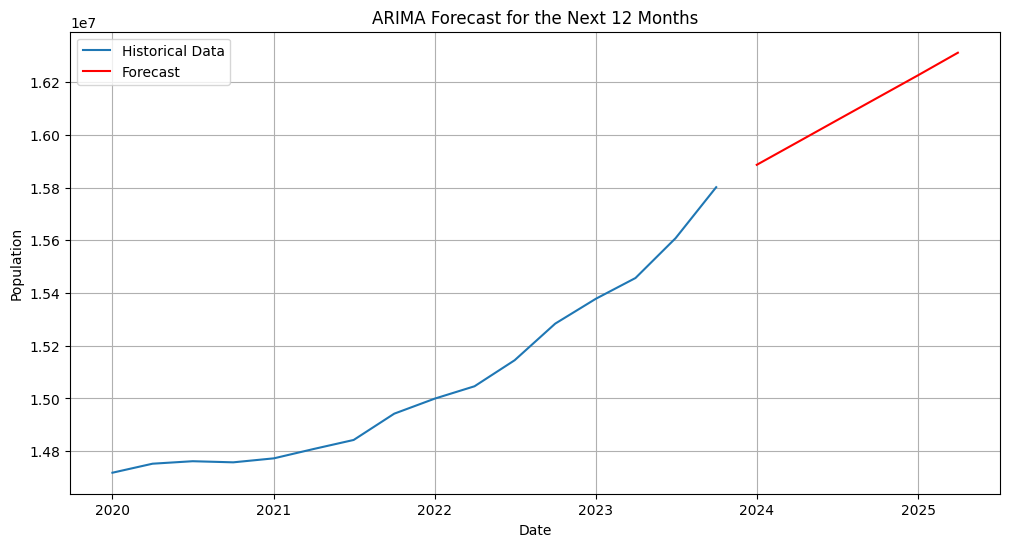

Mean Absolute Error (MAE): 47606.71
Root Mean Squared Error (RMSE): 64006.65
R-squared (R2): 0.84
Mean Absolute Percentage Error (MAPE): 0.30%


In [ ]:
# Fit a new ARIMA model using the optimal parameters and the entire train_data
# new_model = pm.ARIMA(order=(p, d, q))
# new_model_fit = new_model.fit(train_data)
#ontario 1,1,5
#alberta 1,1,6/4
p, d, q =1,1,4
model = ARIMA(selected_data, order=(p, d, q))
model_fit = model.fit()


# Forecast for the next 12 months
forecast_steps = 6
forecast = model_fit.forecast(steps=forecast_steps)

# Print the forecasted values
print("Forecasted Values for the Next 12 Months:")
print(forecast)

# Plotting historical data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(selected_data.index, selected_data['VALUE'], label='Historical Data')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Population')
plt.title('ARIMA Forecast for the Next 12 Months')
plt.legend()
plt.grid(True)

# Set x-axis limits to ensure it starts from the earliest date
plt.show()

import numpy as np

# Calculate Absolute Percentage Error
absolute_percentage_error = np.abs((selected_data['VALUE'].iloc[-forecast_steps:] - forecast) / selected_data['VALUE'].iloc[-forecast_steps:])

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(absolute_percentage_error) * 100

# Print the MAPE



from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Splitting the data into train and test sets
train_size = int(len(selected_data) * 0.8)  # Using 80% of the data for training
train_data, test_data = selected_data['VALUE'][:train_size], selected_data['VALUE'][train_size:]


# Making predictions
start_index = len(train_data)
end_index = start_index + len(test_data) - 1
predictions = model_fit.predict(start=start_index, end=end_index, dynamic=False)

# Calculating evaluation metrics
mae = mean_absolute_error(test_data, predictions)
rmse = np.sqrt(mean_squared_error(test_data, predictions))
r2 = r2_score(test_data, predictions)

# Calculating MAPE
absolute_errors = np.abs(test_data - predictions)
percentage_errors = absolute_errors / test_data
mape = percentage_errors.mean() * 100

# Print the metrics
print("Mean Absolute Error (MAE): {:.2f}".format(mae))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
print("R-squared (R2): {:.2f}".format(r2))
print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))

In [ ]:
last_val_pop=selected_data['VALUE'].iloc[-1:]
last_val_pop=last_val_pop.values
print(last_val_pop)

[15801768]


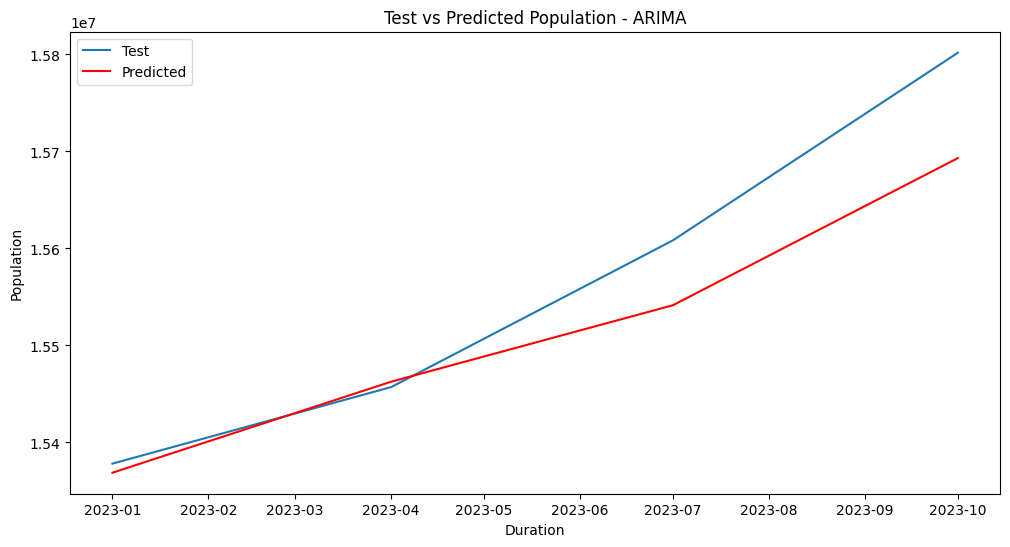

In [ ]:

# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(selected_data.index[train_size:], test_data, label='Test')
plt.plot(selected_data.index[train_size:], predictions, label='Predicted', color='red')
plt.title('Test vs Predicted Population - ARIMA')
plt.xlabel('Duration')
plt.ylabel('Population')
plt.legend()
plt.show()

#Construction

In [ ]:
construction_copy = pd.read_excel("/content/drive/MyDrive/CapstoneOntarioFinalModels/Construction2020-2023.xlsx")
construction_copy.head(2)

,REF_DATE,GEO,DGUID,Housing estimates,Type of unit,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS,Year
0,2020-01-01,Canada,2016A000011124,Housing starts,Total units,Units,300,units,0,v729949,1.1.1,12109,NaN,NaN,NaN,0,2020
1,2020-01-01,Canada,2016A000011124,Housing starts,Single-detached units,Units,300,units,0,v729996,1.1.2,2524,NaN,NaN,NaN,0,2020


In [ ]:
construction_copy = construction_copy[construction_copy['GEO'] == geo_name]

In [ ]:
construction_copy.columns

Index(['REF_DATE', 'GEO', 'DGUID', 'Housing estimates', 'Type of unit', 'UOM',
       'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE',
       'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS', 'Year'],
      dtype='object')

In [ ]:
# # Exclude 'Total Unit' type
# construction_data_filtered = construction_copy[construction_copy['Type of unit'] != 'Total units']

# # Get unique types of units
# unique_types_of_unit = construction_data_filtered['Type of unit'].unique()

# # Create subplots for each type of unit
# fig, axs = plt.subplots(len(unique_types_of_unit), 1, figsize=(8, 6 * len(unique_types_of_unit)), sharex=True)

# # Plotting different charts for each type of unit
# for i, unit_type in enumerate(unique_types_of_unit):
#     # Filter the data for the current type of unit and 'Housing starts' in 2023
#     starts_data = construction_data_filtered[(construction_data_filtered['Type of unit'] == unit_type) &
#                                               (construction_data_filtered['Housing estimates'] == 'Housing starts') &
#                                               (construction_data_filtered['Year'] == 2023)]

#     # Filter the data for the current type of unit and 'Housing completions' in 2023
#     completions_data = construction_data_filtered[(construction_data_filtered['Type of unit'] == unit_type) &
#                                                    (construction_data_filtered['Housing estimates'] == 'Housing completions') &
#                                                    (construction_data_filtered['Year'] == 2022)]

#     # Filter the data for the current type of unit and 'Housing starts' in 2022
#     starts_2022 = construction_data_filtered[(construction_data_filtered['Type of unit'] == unit_type) &
#                                               (construction_data_filtered['Housing estimates'] == 'Housing starts') &
#                                               (construction_data_filtered['Year'] == 2022)]

#     # Plotting the line chart for the current type of unit
#     axs[i].plot(starts_data['REF_DATE'], starts_data['VALUE'], marker='o', linestyle='-', label=f'Housing Starts - {unit_type}')
#     axs[i].plot(completions_data['REF_DATE'], completions_data['VALUE'], marker='o', linestyle='-', label=f'Housing Completions - {unit_type}')
#     axs[i].plot(starts_2022['REF_DATE'], starts_2022['VALUE'], marker='o', linestyle='-', label=f'Completion Expected in 2023 - {unit_type}')

#     # Adding labels, title, legend, and grid
#     axs[i].set_xlabel('Date')
#     axs[i].set_ylabel('Number of Housing Units')
#     axs[i].set_title(f'Housing Starts and Completions for {unit_type} in 2023')
#     axs[i].legend()
#     axs[i].grid(True)

# plt.tight_layout()
# plt.show()


#Calculations

Total predicted population 2024: [254231.8008821]
House needed as per 53 people: 84744
House available: 85770
Total houses needed:  -1026


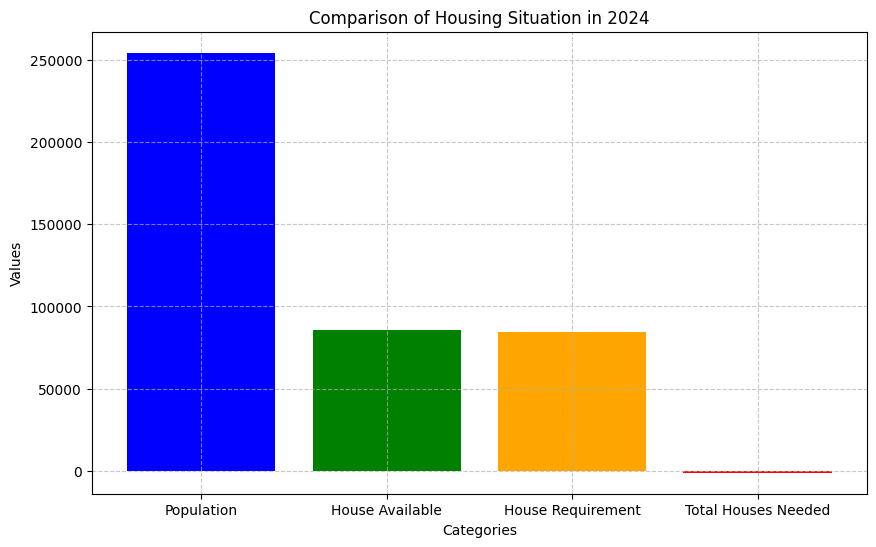

In [ ]:
import math
construction_data_filtered = construction_copy[construction_copy['Type of unit'] == 'Total units']
starts_data = construction_data_filtered[(construction_data_filtered['Housing estimates'] == 'Housing starts') & (construction_data_filtered['Year'] == 2023)]

sum_of_starts = starts_data['VALUE'].sum()

total_val = sum_of_starts

total_predicted_values = forecast[2] - last_val_pop

print("Total predicted population 2024:", total_predicted_values)

total_people = total_predicted_values
house_capacity = 3
houses_needed = math.ceil(total_people / house_capacity)

print("House needed as per 53 people:", houses_needed)
print("House available:", total_val)
print("Total houses needed: ",houses_needed - total_val)


import matplotlib.pyplot as plt

# Given data
labels = ['Population','House Available', 'House Requirement', 'Total Houses Needed']
values = [total_predicted_values[0], total_val,houses_needed, houses_needed - total_val]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Comparison of Housing Situation in 2024')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



#House Price Forecasting

Epoch 1/70
434/434 [==============================] - 5s 4ms/step - loss: 0.0545
Epoch 2/70
434/434 [==============================] - 2s 5ms/step - loss: 0.0472
Epoch 3/70
434/434 [==============================] - 2s 4ms/step - loss: 0.0428
Epoch 4/70
434/434 [==============================] - 3s 7ms/step - loss: 0.0387
Epoch 5/70
434/434 [==============================] - 3s 6ms/step - loss: 0.0384
Epoch 6/70
434/434 [==============================] - 2s 5ms/step - loss: 0.0355
Epoch 7/70
434/434 [==============================] - 2s 5ms/step - loss: 0.0366
Epoch 8/70
434/434 [==============================] - 2s 5ms/step - loss: 0.0343
Epoch 9/70
434/434 [==============================] - 2s 5ms/step - loss: 0.0336
Epoch 10/70
434/434 [==============================] - 3s 6ms/step - loss: 0.0329
Epoch 11/70
434/434 [==============================] - 3s 6ms/step - loss: 0.0315
Epoch 12/70
434/434 [==============================] - 2s 5ms/step - loss: 0.0310
Epoch 13/70
434/434 [====

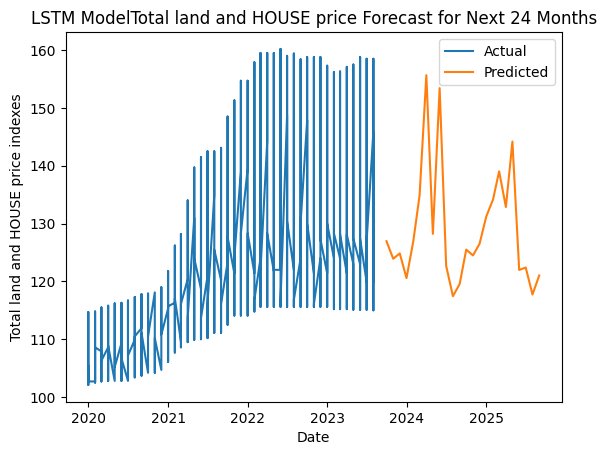

In [ ]:
houseselling_data_copy = pd.read_excel("/content/drive/MyDrive/Capstone Project/House_sellin_2020-2023.xlsx")
houseselling_data_copy.head(2)

houseselling_data_copy = houseselling_data_copy[houseselling_data_copy['GEO_Code'] == geo_code]

columns = ['DGUID', 'UOM','UOM_ID','SCALAR_FACTOR','SCALAR_ID','SCALAR_ID','VECTOR','COORDINATE','STATUS','SYMBOL','TERMINATED','DECIMALS']
houseselling_data = houseselling_data_copy.drop(columns, axis=1)

House_total_price = houseselling_data[houseselling_data['New housing price indexes'] == 'Total (house and land)']
House_only_total = houseselling_data[houseselling_data['New housing price indexes'] == 'House only']
Land_only_total = houseselling_data[houseselling_data['New housing price indexes'] == 'Land only']

House_total_price.columns

#change House_total_price to House_only_total and Land_only_total one by one and run all to see forecast
selected_data = House_total_price[['REF_DATE', 'VALUE']]
selected_data = selected_data.sort_values(by='REF_DATE')

# Assuming selected_data is your DataFrame

# Convert 'REF_DATE' column to datetime
selected_data['REF_DATE'] = pd.to_datetime(selected_data['REF_DATE'])

# Select data with a year less than 2023
selected_data = selected_data[selected_data['REF_DATE'].dt.year <= 2023]
selected_data.head(2)
selected_data.set_index('REF_DATE', inplace=True)


# Assuming selected_data is your DataFrame containing the time series data
# Assuming 'VALUE' is the column you want to forecast

# Prepare the data
data = selected_data['VALUE'].values.reshape(-1, 1)  # Convert to 2D array for scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 6  # Adjust according to your data and task

# Create sequences
X, y = create_sequences(scaled_data, sequence_length)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=70, batch_size=1)

# Generate input sequence for the next 24 months
future_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
future_predictions = []

period = 24
# Make predictions for the next 24 months
for i in range(period):
    prediction = model.predict(future_sequence)
    future_predictions.append(prediction)
    future_sequence = np.append(future_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Inverse scale the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate dates for the next 24 months
last_date = selected_data.index[-1]
future_dates = pd.date_range(start=last_date, periods=period+1, freq='M')[1:]  # Exclude the current month

# Calculate accuracy metrics
actual_values = selected_data['VALUE'].values[-period:]
predicted_values = future_predictions.flatten()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)

# Visualize the predictions
plt.plot(selected_data.index, selected_data['VALUE'], label='Actual')
plt.plot(future_dates, future_predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Total land and HOUSE price indexes')
plt.title('LSTM ModelTotal land and HOUSE price Forecast for Next 24 Months')
plt.legend()
plt.show()

In [ ]:
# houseselling_data_copy = pd.read_excel("/content/drive/MyDrive/Capstone Project/House_sellin_2020-2023.xlsx")
# houseselling_data_copy.head(2)

# houseselling_data_copy = houseselling_data_copy[houseselling_data_copy['GEO_Code'] == geo_code]

# columns = ['DGUID', 'UOM','UOM_ID','SCALAR_FACTOR','SCALAR_ID','SCALAR_ID','VECTOR','COORDINATE','STATUS','SYMBOL','TERMINATED','DECIMALS']
# houseselling_data = houseselling_data_copy.drop(columns, axis=1)

# House_total_price = houseselling_data[houseselling_data['New housing price indexes'] == 'Total (house and land)']
# House_only_total = houseselling_data[houseselling_data['New housing price indexes'] == 'House only']
# Land_only_total = houseselling_data[houseselling_data['New housing price indexes'] == 'Land only']

# House_total_price.columns

# #change House_total_price to House_only_total and Land_only_total one by one and run all to see forecast
# selected_data = House_only_total[['REF_DATE', 'VALUE']]
# selected_data = selected_data.sort_values(by='REF_DATE')

# # Assuming selected_data is your DataFrame

# # Convert 'REF_DATE' column to datetime
# selected_data['REF_DATE'] = pd.to_datetime(selected_data['REF_DATE'])

# # Select data with a year less than 2023
# selected_data = selected_data[selected_data['REF_DATE'].dt.year <= 2023]
# selected_data.head(2)
# selected_data.set_index('REF_DATE', inplace=True)


# # Assuming selected_data is your DataFrame containing the time series data
# # Assuming 'VALUE' is the column you want to forecast

# # Prepare the data
# data = selected_data['VALUE'].values.reshape(-1, 1)  # Convert to 2D array for scaling
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data)

# # Function to create sequences for LSTM
# def create_sequences(data, seq_length):
#     X, y = [], []
#     for i in range(len(data) - seq_length):
#         X.append(data[i:i+seq_length])
#         y.append(data[i+seq_length])
#     return np.array(X), np.array(y)

# # Define sequence length
# sequence_length = 6  # Adjust according to your data and task

# # Create sequences
# X, y = create_sequences(scaled_data, sequence_length)

# # Build the LSTM model
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
# model.add(LSTM(units=50))
# model.add(Dense(units=1))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# model.fit(X, y, epochs=70, batch_size=1)

# # Generate input sequence for the next 24 months
# future_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
# future_predictions = []

# period = 24
# # Make predictions for the next 24 months
# for i in range(period):
#     prediction = model.predict(future_sequence)
#     future_predictions.append(prediction)
#     future_sequence = np.append(future_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# # Inverse scale the predictions
# future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# # Generate dates for the next 24 months
# last_date = selected_data.index[-1]
# future_dates = pd.date_range(start=last_date, periods=period+1, freq='M')[1:]  # Exclude the current month

# # Calculate accuracy metrics
# actual_values = selected_data['VALUE'].values[-period:]
# predicted_values = future_predictions.flatten()

# # Calculate Mean Squared Error (MSE)
# mse = mean_squared_error(actual_values, predicted_values)

# # Calculate Root Mean Squared Error (RMSE)
# rmse = np.sqrt(mse)

# # Calculate Mean Absolute Error (MAE)
# mae = mean_absolute_error(actual_values, predicted_values)

# # Calculate Mean Absolute Percentage Error (MAPE)
# mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

# print("Mean Squared Error (MSE):", mse)
# print("Root Mean Squared Error (RMSE):", rmse)
# print("Mean Absolute Error (MAE):", mae)
# print("Mean Absolute Percentage Error (MAPE):", mape)

# # Visualize the predictions
# plt.plot(selected_data.index, selected_data['VALUE'], label='Actual')
# plt.plot(future_dates, future_predictions, label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Total HOUSE price indexes')
# plt.title('HOUSE price Forecast for Next 24 Months')
# plt.legend()
# plt.show()

In [ ]:
# houseselling_data_copy = pd.read_excel("/content/drive/MyDrive/Capstone Project/House_sellin_2020-2023.xlsx")
# houseselling_data_copy.head(2)

# houseselling_data_copy = houseselling_data_copy[houseselling_data_copy['GEO_Code'] == geo_code]

# columns = ['DGUID', 'UOM','UOM_ID','SCALAR_FACTOR','SCALAR_ID','SCALAR_ID','VECTOR','COORDINATE','STATUS','SYMBOL','TERMINATED','DECIMALS']
# houseselling_data = houseselling_data_copy.drop(columns, axis=1)

# House_total_price = houseselling_data[houseselling_data['New housing price indexes'] == 'Total (house and land)']
# House_only_total = houseselling_data[houseselling_data['New housing price indexes'] == 'House only']
# Land_only_total = houseselling_data[houseselling_data['New housing price indexes'] == 'Land only']

# House_total_price.columns

# #change House_total_price to House_only_total and Land_only_total one by one and run all to see forecast
# selected_data = House_only_total[['REF_DATE', 'VALUE']]
# selected_data = selected_data.sort_values(by='REF_DATE')

# # Assuming selected_data is your DataFrame

# # Convert 'REF_DATE' column to datetime
# selected_data['REF_DATE'] = pd.to_datetime(selected_data['REF_DATE'])

# # Select data with a year less than 2023
# selected_data = selected_data[selected_data['REF_DATE'].dt.year <= 2023]
# selected_data.head(2)
# selected_data.set_index('REF_DATE', inplace=True)


# # Assuming selected_data is your DataFrame containing the time series data
# # Assuming 'VALUE' is the column you want to forecast

# # Prepare the data
# data = selected_data['VALUE'].values.reshape(-1, 1)  # Convert to 2D array for scaling
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data)

# # Function to create sequences for LSTM
# def create_sequences(data, seq_length):
#     X, y = [], []
#     for i in range(len(data) - seq_length):
#         X.append(data[i:i+seq_length])
#         y.append(data[i+seq_length])
#     return np.array(X), np.array(y)

# # Define sequence length
# sequence_length = 6  # Adjust according to your data and task

# # Create sequences
# X, y = create_sequences(scaled_data, sequence_length)

# # Build the LSTM model
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
# model.add(LSTM(units=50))
# model.add(Dense(units=1))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# model.fit(X, y, epochs=70, batch_size=1)

# # Generate input sequence for the next 24 months
# future_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
# future_predictions = []

# period = 24
# # Make predictions for the next 24 months
# for i in range(period):
#     prediction = model.predict(future_sequence)
#     future_predictions.append(prediction)
#     future_sequence = np.append(future_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# # Inverse scale the predictions
# future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# # Generate dates for the next 24 months
# last_date = selected_data.index[-1]
# future_dates = pd.date_range(start=last_date, periods=period+1, freq='M')[1:]  # Exclude the current month

# # Calculate accuracy metrics
# actual_values = selected_data['VALUE'].values[-period:]
# predicted_values = future_predictions.flatten()

# # Calculate Mean Squared Error (MSE)
# mse = mean_squared_error(actual_values, predicted_values)

# # Calculate Root Mean Squared Error (RMSE)
# rmse = np.sqrt(mse)

# # Calculate Mean Absolute Error (MAE)
# mae = mean_absolute_error(actual_values, predicted_values)

# # Calculate Mean Absolute Percentage Error (MAPE)
# mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

# print("Mean Squared Error (MSE):", mse)
# print("Root Mean Squared Error (RMSE):", rmse)
# print("Mean Absolute Error (MAE):", mae)
# print("Mean Absolute Percentage Error (MAPE):", mape)

# # Visualize the predictions
# plt.plot(selected_data.index, selected_data['VALUE'], label='Actual')
# plt.plot(future_dates, future_predictions, label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Total land price indexes')
# plt.title('Land price Forecast for Next 24 Months')
# plt.legend()
# plt.show()